In [1]:
# =====================================
# IMPORT LIBRARIES
# =====================================
import numpy as np
import matplotlib.pyplot as plt
import time
import warnings
warnings.filterwarnings('ignore')

from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

In [2]:
# Load and prepare data
digits = load_digits()
X, y = digits.data, digits.target

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Digits dataset loaded. Training with Random Forest and AdaBoost...")
print(f"Training samples: {X_train.shape[0]}, Test samples: {X_test.shape[0]}")

Digits dataset loaded. Training with Random Forest and AdaBoost...
Training samples: 1437, Test samples: 360


In [3]:
print("\n" + "="*50)
print("PART A: RANDOM FOREST")
print("="*50)

rf_params = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, None]
}

rf_grid = GridSearchCV(
    RandomForestClassifier(oob_score=True, random_state=42),
    rf_params,
    cv=3,
    n_jobs=-1
)

rf_grid.fit(X_train, y_train)
rf = rf_grid.best_estimator_


PART A: RANDOM FOREST


In [4]:
start_time = time.time()
rf.fit(X_train, y_train)
rf_train_time = time.time() - start_time

start_time = time.time()
y_pred_rf = rf.predict(X_test)
rf_pred_time = time.time() - start_time

rf_accuracy = accuracy_score(y_test, y_pred_rf)

print(f"Best RF params: {rf_grid.best_params_}")
print(f"RF Accuracy: {rf_accuracy:.4f}, OOB Error: {1 - rf.oob_score_:.4f}")
print(f"RF Train time: {rf_train_time:.3f}s, Predict time: {rf_pred_time:.3f}s")

Best RF params: {'max_depth': 10, 'n_estimators': 200}
RF Accuracy: 0.9722, OOB Error: 0.0278
RF Train time: 2.525s, Predict time: 0.136s


In [5]:
print("\n" + "="*50)
print("PART B: ADABOOST")
print("="*50)

base_dt = DecisionTreeClassifier(max_depth=1, random_state=42)

ada_params = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.1, 0.5, 1.0]
}

ada_grid = GridSearchCV(
    AdaBoostClassifier(estimator=base_dt, random_state=42),
    ada_params,
    cv=3,
    n_jobs=-1
)

ada_grid.fit(X_train, y_train)
ada = ada_grid.best_estimator_


PART B: ADABOOST


In [6]:
start_time = time.time()
ada.fit(X_train, y_train)
ada_train_time = time.time() - start_time

start_time = time.time()
y_pred_ada = ada.predict(X_test)
ada_pred_time = time.time() - start_time

ada_accuracy = accuracy_score(y_test, y_pred_ada)

print(f"Best AdaBoost params: {ada_grid.best_params_}")
print(f"AdaBoost Accuracy: {ada_accuracy:.4f}")
print(f"AdaBoost Train time: {ada_train_time:.3f}s, Predict time: {ada_pred_time:.3f}s")

Best AdaBoost params: {'learning_rate': 1.0, 'n_estimators': 200}
AdaBoost Accuracy: 0.8639
AdaBoost Train time: 3.136s, Predict time: 0.172s


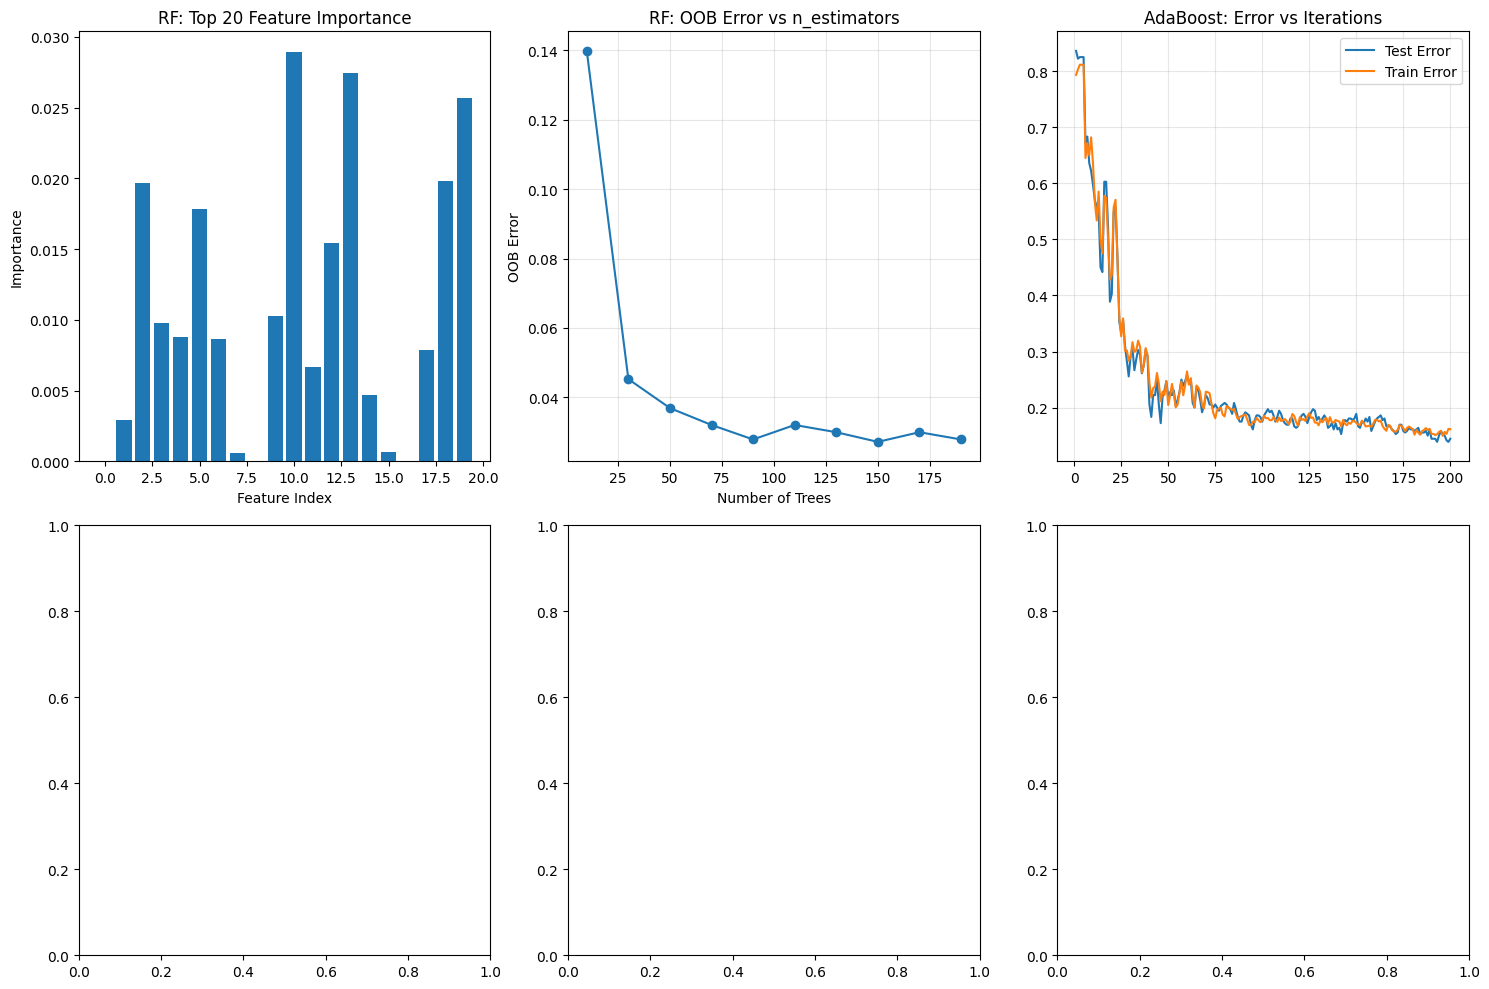

In [7]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# 1️⃣ Feature Importance
axes[0, 0].bar(range(20), rf.feature_importances_[:20])
axes[0, 0].set_title('RF: Top 20 Feature Importance')
axes[0, 0].set_xlabel('Feature Index')
axes[0, 0].set_ylabel('Importance')

# 2️⃣ OOB Error vs Trees
oob_errors = []
for n in range(10, 201, 20):
    rf_temp = RandomForestClassifier(
        n_estimators=n,
        oob_score=True,
        random_state=42,
        n_jobs=-1
    )
    rf_temp.fit(X_train, y_train)
    oob_errors.append(1 - rf_temp.oob_score_)

axes[0, 1].plot(range(10, 201, 20), oob_errors, 'o-')
axes[0, 1].set_title('RF: OOB Error vs n_estimators')
axes[0, 1].set_xlabel('Number of Trees')
axes[0, 1].set_ylabel('OOB Error')
axes[0, 1].grid(True, alpha=0.3)

# 3️⃣ AdaBoost Error vs Iterations
test_errors = []
train_errors = []

ada_temp = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=1),
    n_estimators=200,
    learning_rate=0.5,
    random_state=42
)

ada_temp.fit(X_train, y_train)

for pred in ada_temp.staged_predict(X_test):
    test_errors.append(1 - accuracy_score(y_test, pred))

for pred in ada_temp.staged_predict(X_train):
    train_errors.append(1 - accuracy_score(y_train, pred))

axes[0, 2].plot(range(1, 201), test_errors, label='Test Error')
axes[0, 2].plot(range(1, 201), train_errors, label='Train Error')
axes[0, 2].set_title('AdaBoost: Error vs Iterations')
axes[0, 2].legend()
axes[0, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [8]:
print("\n" + "="*60)
print("COMPARISON TABLE")
print("="*60)

print(f"{'Metric':<25} {'Random Forest':<20} {'AdaBoost':<20}")
print("-" * 60)
print(f"{'Accuracy':<25} {rf_accuracy:<20.4f} {ada_accuracy:<20.4f}")
print(f"{'Training Time (s)':<25} {rf_train_time:<20.3f} {ada_train_time:<20.3f}")
print(f"{'Prediction Time (ms)':<25} {rf_pred_time*1000:<20.2f} {ada_pred_time*1000:<20.2f}")
print(f"{'OOB/Test Error':<25} {1-rf.oob_score_:<20.4f} {1-ada_accuracy:<20.4f}")
print("-" * 60)


COMPARISON TABLE
Metric                    Random Forest        AdaBoost            
------------------------------------------------------------
Accuracy                  0.9722               0.8639              
Training Time (s)         2.525                3.136               
Prediction Time (ms)      135.98               172.09              
OOB/Test Error            0.0278               0.1361              
------------------------------------------------------------
